In [248]:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier



In [195]:
data=pd.read_csv('term-deposit-marketing-2020.csv')

In [196]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [197]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [198]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [199]:
data['y']= np.where(data.y=='yes',1,0)

In [200]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0


In [201]:
obj_col = data.select_dtypes(include=['object']).columns
df_dummies = pd.get_dummies(data[obj_col])
data_with_dummies = pd.concat([data, df_dummies], axis=1)
data_with_dummies =data_with_dummies.drop(obj_col, axis=1)


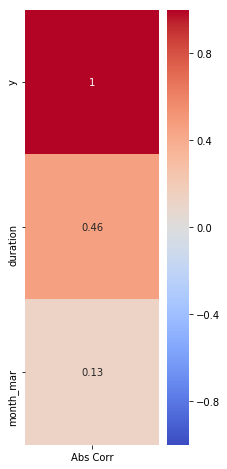

In [202]:
correlations = data_with_dummies.corrwith(data_with_dummies['y']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(3,8))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.1], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

In [203]:
df_num_corr = data_with_dummies.corr()['y']
features_list = df_num_corr[abs(df_num_corr) > 0.05].sort_values(ascending=False)
print("There is {} strongly correlated values with target:\n{}".format(len(features_list),features_list))

There is 11 strongly correlated values with target:
y                   1.000000
duration            0.461169
month_mar           0.128125
month_apr           0.097450
month_oct           0.093298
contact_cellular    0.085433
housing_no          0.054336
marital_single      0.051721
housing_yes        -0.054336
marital_married    -0.056863
contact_unknown    -0.088408
Name: y, dtype: float64


In [208]:
def get_model_results( y_test, pred): 
    acc = accuracy_score(y_test, pred, normalize=True)
    print(' Model Accuracy:%.2f'%acc)
    print ('\n classification report :\n')
    print(classification_report(y_test, pred))
    print('f1_score:'+str(f1_score(y_test, pred)))
    print('\n precision:'+str(precision_score(y_test, pred)))
    print('\n recall:'+str(recall_score(y_test, pred)))
    print ('\n confussion matrix:\n',confusion_matrix(y_test, pred))

In [241]:

X_train, X_test, y_train, y_test = train_test_split(data_with_dummies[features_list.index].drop('y', axis=1), data_with_dummies.y, test_size=0.3, random_state=0)

In [210]:
classifier=XGBClassifier()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
get_model_results(y_test, pred)


 Model Accuracy:0.94

 classification report :

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11152
           1       0.58      0.31      0.40       848

    accuracy                           0.94     12000
   macro avg       0.76      0.65      0.68     12000
weighted avg       0.92      0.94      0.93     12000

f1_score:0.40399385560675877

 precision:0.579295154185022

 recall:0.31014150943396224

 confussion matrix:
 [[10961   191]
 [  585   263]]


In [174]:
# print(classifier.feature_importances_)

#### results above is taken on unbalanced data. Accuracy:0.94 is not important cause recall and precision is  low. Model tends to predict that label is 1 as 0 because of its being unbalanced.We can also see that from FN value(585 among 848) and TN value on confusion matrix. So we obtained high Accuracy but it is not acceptible.Resampling method on trainset is needed. In addition, cross validation results below show that model has high variance, results are changable.

#### cv=5 CROSS VALIDAION RESULTS

In [211]:
classifier= XGBClassifier()
#print(str(cross_val_score(pipeline, X_all, y_all, cv=5, scoring='f1')))
print('F1 Score cross-validtion results \n')
print(cross_val_score(classifier, data_with_dummies.drop('y', axis=1), data_with_dummies.y, cv=5, scoring='f1'))

F1 Score cross-validtion results 

[0.00344828 0.0295203  0.00472069 0.02860286 0.2064552 ]


In [212]:
classifier= XGBClassifier()
#print(str(cross_val_score(pipeline, X_all, y_all, cv=5, scoring='f1')))
print('Accuracy cross-validtion results \n')
print(cross_val_score(classifier, data_with_dummies.drop('y', axis=1), data_with_dummies.y, cv=5, scoring='accuracy'))

Accuracy cross-validtion results 

[0.92775  0.737    0.841875 0.227375 0.6435  ]


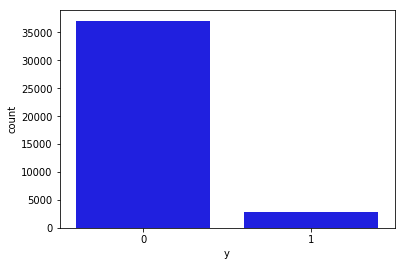

In [213]:
ax = sns.countplot('y',data=data_with_dummies, color='blue')


## OVERSAMPLING METHOD ON TRAINSET

In [242]:
train= pd.concat([X_train, y_train], axis=1)
cnt_0, cnt_1 = train.y.value_counts()
print('cnt0 :'+str(cnt_0)+ '     cnt1: '+str(cnt_1))
df_class_0 = train[train['y'] == 0]
df_class_1 = train[train['y'] == 1]


cnt0 :25952     cnt1: 2048


In [243]:
df_class_1_over = df_class_1.sample(cnt_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_over =df_over.reset_index().drop('index',axis=1)
X_train=df_over.drop('y',axis=1)
y_train=df_over['y']






In [244]:
classifier=XGBClassifier()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [245]:
get_model_results(y_test, pred)

 Model Accuracy:0.86

 classification report :

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     11152
           1       0.31      0.82      0.45       848

    accuracy                           0.86     12000
   macro avg       0.65      0.84      0.68     12000
weighted avg       0.94      0.86      0.89     12000

f1_score:0.44995172191824917

 precision:0.3094289508632138

 recall:0.8242924528301887

 confussion matrix:
 [[9592 1560]
 [ 149  699]]


#### As a result, after resampling, TN value decreased, FP value increased. at least we lowered the model's tendency to predict 0 because of the unbalacity of the data. We need high precision and recall, but in the model, precision is lower than recall. I mean, while recall(the correct estimation rate of customer's buying) is 0.824, precision (How many of customers we predict bought are really bought) is 0.309. F-score helps measure precision and recall at the same time. It uses harmonic averages rather than arithmetic averages, punishing excessive values more.It seems that F1 score is increased after resampling but still low.

## BEST ALGORITHM SLECTION

In [250]:
algorithms=[XGBClassifier(), GradientBoostingClassifier(),RandomForestClassifier(), DecisionTreeClassifier(), MultinomialNB(),SVC()]
for est in algorithms:
    print(str(est)+': \n')
    cf=est
    cf.fit(X_train, y_train)
    pred = cf.predict(X_test)
    get_model_results( y_test,pred)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1): 

 Model Accuracy:0.86

 classification report :

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     11152
           1       0.31      0.82      0.45       848

    accuracy                           0.86     12000
   macro avg       0.65      0.84      0.68     12000
weighted avg       0.94      0.86      0.89     12000

f1_score:0.44995172191824917

 precision:0.3094289508632138

 recall:0.8242924528301887

 confussion matrix:
 [[9592 1560]
 [ 149  699]]
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_

## ROC CURVE ANALYSIS

In [253]:
def get_roccurve_metrics(X_train,y_train, X_test, est): 
    classifier = est
    target = y_train
    classifier = classifier.fit(X_train, target)
    probs = classifier.predict_proba(X_test)
    pred = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, roc_auc

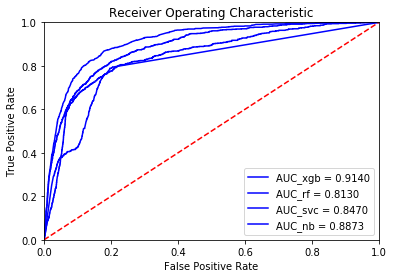

In [254]:

fpr_xgb, tpr_xgb,roc_auc_xgb= get_roccurve_metrics(X_train,y_train, X_test, XGBClassifier())
fpr_rf, tpr_rf,roc_auc_rf= get_roccurve_metrics(X_train,y_train, X_test, RandomForestClassifier())
fpr_svc, tpr_svc,roc_auc_svc= get_roccurve_metrics(X_train,y_train, X_test, SVC(probability=True))
fpr_nb, tpr_nb,roc_auc_nb= get_roccurve_metrics(X_train,y_train, X_test, MultinomialNB())




plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb, tpr_xgb, 'b', label = 'AUC_xgb = %0.4f' % roc_auc_xgb)
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC_rf = %0.4f' % roc_auc_rf)
plt.plot(fpr_svc, tpr_svc, 'b', label = 'AUC_svc = %0.4f' % roc_auc_svc)
plt.plot(fpr_nb, tpr_nb, 'b', label = 'AUC_nb = %0.4f' % roc_auc_nb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



##  HYPERPARAMETER OPTIMIZATION USING GRIDSEARCH

In [185]:
classifier.fit(X_train,y_train)

parameters = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5]}

grid_search_tune = GridSearchCV(classifier, parameters, cv=5, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   28.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 15.9min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 23.6min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 33.3min
[Parallel(n_jobs=2)]: Done 2025 out of 2025 | elapsed: 44.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1),
             iid='deprecated', n_jobs=2,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
               

In [187]:
print("Best parameters set:")
print(grid_search_tune.best_estimator_)

Best parameters set:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1.0, gamma=1, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6)


In [188]:
classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1.0, gamma=1, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
print(classification_report(y_test, pred))
print('\n accuracy:'+str(accuracy_score(y_test, pred)))
print('f1_score:'+str(f1_score(y_test, pred)))
print('\n precision:'+str(precision_score(y_test, pred)))
print('\n recall:'+str(recall_score(y_test, pred)))
print('\n confusion matrix:\n'+str(confusion_matrix(y_test, pred)))


              precision    recall  f1-score   support

           0       0.98      0.86      0.92     11152
           1       0.31      0.81      0.45       848

    accuracy                           0.86     12000
   macro avg       0.65      0.84      0.68     12000
weighted avg       0.94      0.86      0.89     12000


 accuracy:0.8594166666666667
f1_score:0.45030954708374066

 precision:0.31112111661413777

 recall:0.8148584905660378

 confusion matrix:
[[9622 1530]
 [ 157  691]]


#### CONCLUSION
Data was actually highly unbalance, so I applied the resampling method on the trainset to balance the data. Before applying this method, I also got results on unbalance data to compare the results. The results I get over unbalanced data show that accuracy is very high but this is not important, because model tends to predict that label is 1 as 0. It is clearly visible in the confusion matrix. After balancing the data on the trainset, TN value decreased, FP value increased. at least we lowered the model's tendency to predict 0 because of the unbalacity of the data. At the same time, accuracy decreased, f1 score increased.This scenario is more acceptable than unbalanced data with high accuracy but model has still low precison and F1 score. (detailed descriptions above are available).  XGBoost has higher AUC and F1-Score, is the best among other classifiers. After selecting best algorithm, best parameters was chosen for XGBoost thanks to Gridsearch.


As can be seen in correlation matrix, with the correlation rate of 0.46,
the variable most associated with the customer's buying is the last contact duration. It is  followed by month March that has a very low correlation with a correlation rate of 0.12.

In [256]:
data.groupby('y')['balance'].mean()

y
0    1249.752533
1    1588.495856
Name: balance, dtype: float64

In [264]:
cnt0, cnt1=data.y.value_counts()

#### 61 percent of non-subscribers own homes, Percentages of subscribing customers who have home or not are very close to each other, there is no distinction.

In [292]:
analysis_housing = pd.DataFrame(data=data.groupby(['housing','y'])['campaign'].count()).reset_index()
analysis_housing['percentage']= np.where (analysis_housing.y==0, analysis_housing.campaign/cnt0, analysis_housing.campaign/cnt1)
analysis_housing[['housing','y','percentage']]

,housing,y,percentage
0,no,0,0.391791
1,no,1,0.494475
2,yes,0,0.608209
3,yes,1,0.505525


#### The average age of subscribers and non-subscribers is very close

In [290]:
data.groupby('y')['age'].mean()

y
0    40.599208
1    39.844959
Name: age, dtype: float64

#### There is a distinction according to the duration.The last contact duration of subscribed customers is almost 3 times the last contact duration of non-subscribers.

In [289]:
data.groupby('y')['duration'].mean()

y
0    221.408042
1    682.958564
Name: duration, dtype: float64

#### The majority of subscribed and unsubscribed customers do not have loan

In [295]:
analysis_loan = pd.DataFrame(data=data.groupby(['loan','y'])['campaign'].count()).reset_index()
analysis_loan['percentage']= np.where (analysis_loan.y==0, analysis_loan.campaign/cnt0, analysis_loan.campaign/cnt1)
analysis_loan[['loan','y','percentage']]
 

,loan,y,percentage
0,no,0,0.823469
1,no,1,0.868785
2,yes,0,0.176531
3,yes,1,0.131215


#### Job has no pattern on subscribing or not

In [293]:
analysis_job = pd.DataFrame(data=data.groupby(['job','y'])['campaign'].count()).reset_index()
 
analysis_job['percentage']= np.where (analysis_job.y==0, analysis_job.campaign/cnt0, analysis_job.campaign/cnt1)
analysis_job[['job','y','percentage']]
 

,job,y,percentage
0,admin,0,0.111363
1,admin,1,0.121202
2,blue-collar,0,0.238465
3,blue-collar,1,0.184738
4,entrepreneur,0,0.035495
5,entrepreneur,1,0.030387
6,housemaid,0,0.027868
7,housemaid,1,0.018301
8,management,0,0.201865
9,management,1,0.233425


In [296]:
analysis_edu = pd.DataFrame(data=data.groupby(['education','y'])['campaign'].count()).reset_index()
analysis_edu['percentage']= np.where (analysis_edu.y==0, analysis_edu.campaign/cnt0, analysis_edu.campaign/cnt1)
analysis_edu[['education','y','percentage']]

,education,y,percentage
0,primary,0,0.159471
1,primary,1,0.121892
2,secondary,0,0.527571
3,secondary,1,0.489641
4,tertiary,0,0.274283
5,tertiary,1,0.355318
6,unknown,0,0.038675
7,unknown,1,0.033149
